<p> 
A SparkContext gets created
</p>

In [1]:
import pyspark
from pyspark import Row
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from numpy import array
from math import sqrt
import sys

from pyspark.mllib.clustering import KMeans, KMeansModel

sc = pyspark.SparkContext('local[*]')
sc._conf.set("spark.executor.memory", "12g")
sc._conf.set("spark.driver.memory", "12g")
sqlContext = pyspark.SQLContext(sc)

<p> 
Data gets loaded from a parquet file named "stackoverflow.parquet", which is later turned into dataframes.
</p>

In [2]:
df = sqlContext.read.parquet("stackoverflow.parquet")

Posting = Row('question_answer', 'id', 'accepted_answer', 'parentId', 'score', 'language')

posting = df.rdd.map(lambda r: Posting(*r))

df = sqlContext.createDataFrame(posting, samplingRatio=0.1)

In [3]:
# Languages
languages = ["JavaScript", "Java", "PHP", "Python", "C#", "C++", "Ruby", "CSS",
      "Objective-C", "Perl", "Scala", "Haskell", "MATLAB", "Clojure", "Groovy"]

# How spread apart should the languages be for the K-Clustering algorithm
langSpread = 50000

# Number of clusters 
kmeansKernels = 45

# Convergence Criterion
kmeansEta = 20.0

# Max number of iterations
kmeansMaxIterations = 120

In [4]:
questions = df.filter(df['question_answer'] == 1).rdd.map(lambda q: (q.id, q))
answers = df.filter(df['question_answer'] == 2).rdd.map(lambda a: (a.parentId, a))

group_questions_and_answers = questions.join(answers).groupByKey()

In [5]:
def max_score(v):
    return max(map(lambda r: r.score, list(v)))

score_by_question = group_questions_and_answers.flatMap(lambda v: v[1]).groupByKey().mapValues(max_score)

print(score_by_question.take(1)[0])


(Row(question_answer='1', id='21167403', accepted_answer=None, parentId=None, score='0', language='PHP'), '0')


In [6]:
def getindexdefault(self, elem):
        try:
            idx = self.index(elem)
            return idx
        except ValueError:
            return -1

def first_language_in_languages(tag):
    idx = getindexdefault(languages, tag)
    if idx >= 0:
        return idx
    else:
        return -1

        

vectors = score_by_question.filter(lambda x:  x[0].language is not u'').map(lambda x: ((first_language_in_languages(x[0].language)+1) * langSpread , x[1]))

vectors.persist()



PythonRDD[35] at RDD at PythonRDD.scala:53

In [7]:
print(vectors.take(50))

[(150000, '0'), (150000, '-1'), (150000, '1'), (150000, '0'), (150000, '0'), (200000, '0'), (150000, '0'), (300000, '0'), (100000, '911'), (150000, '2'), (150000, '1'), (400000, '3'), (300000, '0'), (300000, '0'), (200000, '9'), (150000, '0'), (300000, '0'), (200000, '6'), (300000, '0'), (150000, '0'), (150000, '0'), (200000, '2'), (150000, '0'), (150000, '0'), (150000, '1'), (150000, '-2'), (300000, '1'), (150000, '0'), (300000, '2'), (150000, '2'), (150000, '1'), (300000, '7'), (150000, '0'), (150000, '0'), (300000, '2'), (150000, '1'), (300000, '4'), (150000, '0'), (400000, '4'), (300000, '1'), (300000, '2'), (150000, '0'), (150000, '0'), (150000, '1'), (300000, '3'), (150000, '0'), (150000, '0'), (150000, '1'), (250000, '20'), (150000, '2')]


In [8]:
by_language = kmeansKernels / len(languages)



In [9]:
# Train model

clusters = KMeans.train(vectors, kmeansKernels, maxIterations=kmeansMaxIterations, initializationMode="random")


In [10]:
NewPosting = Row('language', 'score')

posting = vectors.map(lambda r: NewPosting(*r))

new_df = sqlContext.createDataFrame(posting, samplingRatio=0.1)

new_df.show()

+--------+-----+
|language|score|
+--------+-----+
|  150000|    0|
|  150000|   -1|
|  150000|    1|
|  150000|    0|
|  150000|    0|
|  200000|    0|
|  150000|    0|
|  300000|    0|
|  100000|  911|
|  150000|    2|
|  150000|    1|
|  400000|    3|
|  300000|    0|
|  300000|    0|
|  200000|    9|
|  150000|    0|
|  300000|    0|
|  200000|    6|
|  300000|    0|
|  150000|    0|
+--------+-----+
only showing top 20 rows



+--------+-----+----------------+
|language|score|        features|
+--------+-----+----------------+
|  150000|    0|  [150000.0,0.0]|
|  150000|   -1| [150000.0,-1.0]|
|  150000|    1|  [150000.0,1.0]|
|  150000|    0|  [150000.0,0.0]|
|  150000|    0|  [150000.0,0.0]|
|  200000|    0|  [200000.0,0.0]|
|  150000|    0|  [150000.0,0.0]|
|  300000|    0|  [300000.0,0.0]|
|  100000|  911|[100000.0,911.0]|
|  150000|    2|  [150000.0,2.0]|
|  150000|    1|  [150000.0,1.0]|
|  400000|    3|  [400000.0,3.0]|
|  300000|    0|  [300000.0,0.0]|
|  300000|    0|  [300000.0,0.0]|
|  200000|    9|  [200000.0,9.0]|
|  150000|    0|  [150000.0,0.0]|
|  300000|    0|  [300000.0,0.0]|
|  200000|    6|  [200000.0,6.0]|
|  300000|    0|  [300000.0,0.0]|
|  150000|    0|  [150000.0,0.0]|
+--------+-----+----------------+
only showing top 20 rows



Text(0, 0.5, 'cost')

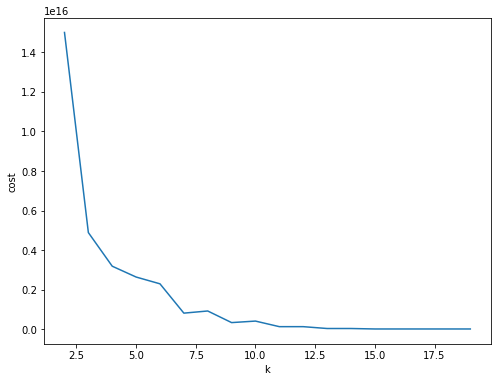

In [11]:
from pyspark.ml.feature import VectorAssembler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyspark.ml.clustering import KMeans


FEATURES_COL = ['language', 'score']

for col in df.columns:
    if col in FEATURES_COL:
        new_df = new_df.withColumn(col,new_df[col].cast('int'))

new_df = new_df.na.drop()
new_df.schema

vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(new_df).select('language', 'score', 'features')
df_kmeans.show()

cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later
    
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [12]:
kmeans = KMeans().setK(kmeansKernels).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[2.50000000e+05 1.10453231e+00]
[4.00000000e+05 2.11342948e+00]
[1.00000000e+05 4.47869599e-01]
[1.50000000e+05 4.18475448e-01]
[7.00000000e+05 4.43146836e+00]
[5.00000000e+04 4.90311486e+00]
[6.00000000e+05 5.27862957e+00]
[2.00000000e+05 7.32137067e+00]
[3.00000000e+05 2.67391943e+00]
[5.00000000e+05 3.15579167e+00]
[4.50000000e+05 1.53871322e+00]
[5.50000000e+05 4.27435975e+00]
[6.50000000e+05 2.20327167e+00]
[7.50000000e+05 2.56927612e+00]
[3.50000000e+05 3.25160207e+00]
[250000.            640.33333333]
[1.00000000e+05 6.20447691e+01]
[100000.       728.375]
[1.5000000e+05 1.0623815e+01]
[2.00000000e+05 8.41061693e+01]
[50000.           366.47368421]
[300000.            592.90909091]
[50000.            78.92704918]
[2.50000000e+05 6.54045293e+01]
[400000.        696.9375]
[350000.            598.16666667]
[4.50000000e+05 7.83899557e+01]
[100000.            247.35897436]
[1.00000000e+05 9.02687995e+00]
[5.00000000e+04 7.43837808e-01]
[200000.            644.333333

In [13]:
transformed = model.transform(df_kmeans).select('language', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(language=150000, prediction=3), Row(language=150000, prediction=3), Row(language=150000, prediction=3)]


In [14]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+--------+----------+
|language|prediction|
+--------+----------+
|  150000|         3|
|  150000|         3|
|  150000|         3|
|  150000|         3|
|  150000|         3|
|  200000|        35|
|  150000|         3|
|  300000|         8|
|  100000|        17|
|  150000|        36|
|  150000|         3|
|  400000|         1|
|  300000|         8|
|  300000|         8|
|  200000|         7|
|  150000|         3|
|  300000|         8|
|  200000|         7|
|  300000|         8|
|  150000|         3|
+--------+----------+
only showing top 20 rows



In [15]:
df_pred = df_pred.join(new_df, 'language')
df_pred.show()

+--------+----------+-----+
|language|prediction|score|
+--------+----------+-----+
|  350000|        14|   12|
|  350000|        14|    5|
|  350000|        14|    9|
|  350000|        14|    6|
|  350000|        14|    6|
|  350000|        14|    6|
|  350000|        14|   14|
|  350000|        14|    4|
|  350000|        14|    0|
|  350000|        14|    7|
|  350000|        14|    3|
|  350000|        14|    5|
|  350000|        14|    1|
|  350000|        14|    9|
|  350000|        14|    9|
|  350000|        14|    3|
|  350000|        14|    6|
|  350000|        14|   16|
|  350000|        14|    4|
|  350000|        14|    2|
+--------+----------+-----+
only showing top 20 rows



In [16]:
print(df_pred.take(3))


[Row(language=350000, prediction=14, score=12), Row(language=350000, prediction=14, score=5), Row(language=350000, prediction=14, score=9)]


In [17]:
pddf_pred = df_pred.sample(False, 0.00001).toPandas()


In [18]:
pddf_pred.head()

,language,prediction,score
0,350000,14,0
1,350000,14,1
2,350000,14,1
3,350000,14,0
4,350000,14,8


In [19]:

print(pddf_pred.shape) 

(6043377, 3)


In [20]:
pddf_pred.to_csv('pandas_csv.csv')

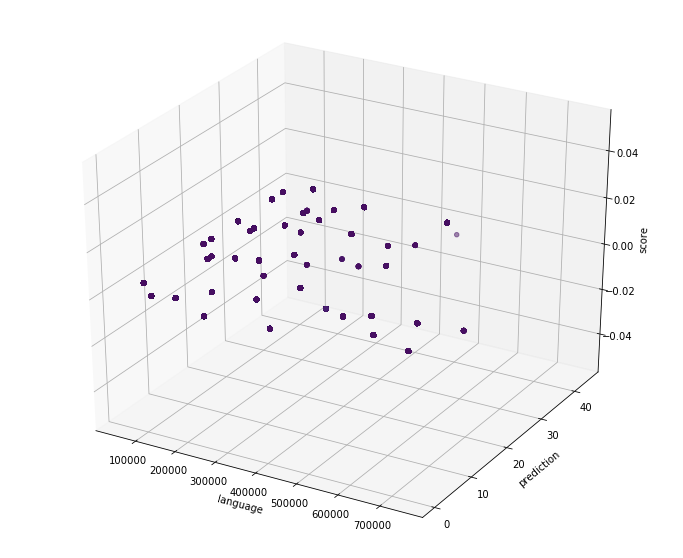

In [21]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.language, pddf_pred.prediction, c=pddf_pred.score)
threedee.set_xlabel('language')
threedee.set_ylabel('prediction')
threedee.set_zlabel('score')
plt.show()